In [1]:
import wandb
import numpy as np
import os
import random
import glob
import pandas as pd
import time
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import importlib
from common import common
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier, VotingClassifier
from sklearn.datasets import fetch_covtype
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.io import arff
from sklearn.datasets import fetch_openml
from joblib import Parallel, delayed
from concurrent.futures import ProcessPoolExecutor
from functools import partial
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import export_text
from concurrent.futures import ThreadPoolExecutor, as_completed

In [2]:
wandb.login()

wandb: Currently logged in as: brinashong. Use `wandb login --relogin` to force relogin


True

In [3]:
# Reload common module
importlib.reload(common)

<module 'common.common' from '/home/brina/nus-mcomp/sem2/cs5344-big-data-analytics-technology/CS5344_Project.git/master/work/common/common.py'>

In [4]:
# Shared variables
OUTPUT_FOLDER = 'csv_files'
FEATURE_FOLDER = 'features'

In [5]:
# project name should correspond to dataset below
project_name = "thyroid"
# project_name = "cirrhosis"
# project_name = "heart"
# project_name = "hepatitis"

In [6]:
if project_name == "thyroid":
    %run datasets/thyroid.ipynb
    all_df, main_labels, config = get_processed_thyroid_df()
elif project_name == "cirrhosis":
    %run datasets/cirrhosis.ipynb
    all_df, main_labels, config = get_processed_cirrhosis_df()
elif project_name == "heart":
    %run datasets/heart.ipynb
    all_df, main_labels, config = get_processed_heart_df()
else:
    %run datasets/hepatitis.ipynb
    all_df, main_labels, config = get_processed_hepatitis_df()

Normal class:  0    Benign
dtype: object
TARGET_DICT {0: 'Benign', 1: 'Botnet', 2: 'Bruteforce', 3: 'DDoS', 4: 'DoS', 5: 'Infiltration', 6: 'Portscan', 7: 'Webattack'}
NORMAL_TARGET 0
main_labels Index(['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
       'Fwd Packets Length Total', 'Bwd Packets Length Total',
       'Fwd Packet Length Max', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s',
       'Bwd Packets/s', 'Packet Length Max', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'SYN Flag 

In [7]:
# Should already be one hot encoded and label encoded
TARGET_COLUMN = config['TARGET_COLUMN']
NORMAL_TARGET = config['NORMAL_TARGET']
TARGET_DICT = config['TARGET_DICT']
INV_TARGET_DICT = config['INV_TARGET_DICT']
NUMERICAL_COLUMNS = config['NUMERICAL_COLUMNS']
CATEGORICAL_COLUMNS = config['CATEGORICAL_COLUMNS']
ORDINAL_COLUMNS = config['ORDINAL_COLUMNS']
all_df.head()

,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Mean,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ClassLabel
0,51990738,3,1,43.0,6.0,31.0,14.333333,14.433757,6.0,6.00000,...,20,0.0,0.0,0.0,0.0,51940550.0,0.00,51940552.0,51940552.0,0
1,117384013,80,144,974.0,199741.0,275.0,12.175000,44.683636,1460.0,1387.09030,...,20,506187.0,628091.8,950315.0,62059.0,58155176.0,132745.16,58249039.0,58061309.0,0
2,246,2,2,64.0,204.0,32.0,32.000000,0.000000,102.0,102.00000,...,32,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0
3,200929,13,11,1293.0,4610.0,694.0,99.461540,189.770750,1430.0,419.09090,...,20,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0
4,2446230,8,7,1144.0,1581.0,677.0,143.000000,227.969920,1173.0,225.85715,...,20,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0


In [8]:
all_df.shape

(2037240, 58)

In [114]:
# Create a folder to save the CSVs
common.remove_files_from_directory(OUTPUT_FOLDER)
common.remove_files_from_directory(FEATURE_FOLDER)
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
os.makedirs(FEATURE_FOLDER, exist_ok=True)

All files in csv_files have been removed.
All files in features have been removed.


In [9]:
# Save all data as csv
all_df.to_csv('all_data.csv' ,index = False)

In [10]:
# Get X and y from all_df
X_df = all_df.drop(columns=[TARGET_COLUMN])
y_df = all_df[TARGET_COLUMN]

# Split the data into training and test sets
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, test_size=0.2, random_state=42)
print(X_train_df.shape, X_test_df.shape, y_train_df.shape, y_test_df.shape)

(1629792, 57) (407448, 57) (1629792,) (407448,)


In [11]:
# Concatenate X_train and y_train along the columns (axis=1)
X_y_train_df = pd.concat([X_train_df, y_train_df], axis=1)
X_y_train_df.head()

,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Mean,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ClassLabel
1285014,3850770,14,8,1440.0,1731.0,725.0,102.857140,191.172840,1179.0,216.375,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1142876,4664549,5,4,935.0,790.0,935.0,187.000000,418.144700,395.0,197.500,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1229394,1301287,6,5,455.0,338.0,140.0,75.833336,62.936210,145.0,67.600,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
957100,60002992,2,0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000,...,0,0.0,0.0,0.0,0.0,60000000.0,0.0,60000000.0,60000000.0,0
1567448,5048320,3,1,12.0,2.0,6.0,4.000000,3.464102,2.0,2.000,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [12]:
# Fit and transform the numeric columns
scaler, X_train_scaled_df = common.standardise(X_train_df, NUMERICAL_COLUMNS)
# print('X_train_scaled_df', X_train_scaled_df)

# Use the same scaler to transform X_test
scaler, X_test_scaled_df = common.standardise(X_test_df, NUMERICAL_COLUMNS, scaler=scaler)
# print('X_test_scaled_df', X_test_scaled_df)

In [13]:
X_test_scaled_df.head()

,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Mean,...,Fwd Act Data Packets,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
493261,-0.020415,-0.015738,-0.004453,-0.012115,-0.006301,0.764742,0.436446,0.624745,0.478884,0.067964,...,-0.015134,0.032096,-0.078654,-0.063697,-0.096529,-0.064852,-0.028091,-0.002339,-0.012429,-0.309088
892391,-0.006094,-0.017676,-0.008706,-0.021371,-0.006688,0.326702,0.235001,0.629947,0.308839,0.113181,...,-0.017087,0.032096,-0.077826,-0.063697,-0.095915,-0.063886,-0.003148,-0.002339,-0.002144,-0.016888
1287921,-0.023986,-0.018645,-0.012959,-0.027550,-0.007306,-0.589382,-0.574314,-0.526563,-0.513469,-0.527766,...,-0.017576,0.032096,-0.078654,-0.063697,-0.096529,-0.064852,-0.028091,-0.002339,-0.012429,-0.309088
1640422,-0.022599,-0.018161,-0.008706,-0.027281,-0.006693,-0.549378,-0.527192,-0.468247,0.302071,0.107906,...,-0.017087,0.032096,-0.078654,-0.063697,-0.096529,-0.064852,-0.028091,-0.002339,-0.012429,-0.309088
862681,-0.024291,-0.018645,-0.011541,-0.026660,-0.007201,-0.523376,-0.341062,-0.526563,-0.443251,-0.308842,...,-0.017087,0.032095,-0.078654,-0.063697,-0.096529,-0.064852,-0.028091,-0.002339,-0.012429,-0.309088


In [14]:
seconds = time.time()

benign = 2359289
abnormal_type_counts = all_df[TARGET_COLUMN].value_counts()
abnormal_type_dict = abnormal_type_counts.to_dict()
print('abnormal_type_dict', abnormal_type_dict)
target_index = all_df.columns.get_loc(TARGET_COLUMN)
benign_ratio = 3  # Adjust this ratio as needed
min_benign_samples = 50  # Ensure at least 50 benign samples are always included

# Linear method
for label, name in TARGET_DICT.items():
    if label == NORMAL_TARGET:
        continue  # Skip the normal target
    
    common.create_dataset_for_label(label, name, benign, abnormal_type_dict, benign_ratio, min_benign_samples, all_df, target_index, TARGET_COLUMN, NORMAL_TARGET, OUTPUT_FOLDER, main_labels)
    
# Parallel execution to create the anomaly datasets for each anomaly class
# def create_dataset(label, name, benign, abnormal_type_dict, benign_ratio, min_benign_samples, all_df, target_index, TARGET_COLUMN, NORMAL_TARGET, OUTPUT_FOLDER, main_labels):
#     return common.create_dataset_for_label(label, name, benign, abnormal_type_dict, benign_ratio, min_benign_samples, all_df, target_index, TARGET_COLUMN, NORMAL_TARGET, OUTPUT_FOLDER, main_labels)

# # Using Joblib to parallelize the dataset creation
# results = Parallel(n_jobs=-1)(
#     delayed(create_dataset)(label, name, benign, abnormal_type_dict, benign_ratio, min_benign_samples, all_df, target_index, TARGET_COLUMN, NORMAL_TARGET, OUTPUT_FOLDER, main_labels)
#     for label, name in TARGET_DICT.items() if label != NORMAL_TARGET
# )

print("All datasets created successfully!")
print("Total operation time: =", time.time() - seconds, "seconds")

abnormal_type_dict {0: 1597040, 3: 274283, 4: 87943, 1: 32390, 2: 23289, 5: 21107, 7: 686, 6: 502}
Botnet.csv created with 129560 rows. (97170 benign and 32390 abnormal rows)
Bruteforce.csv created with 93156 rows. (69867 benign and 23289 abnormal rows)
DDoS.csv created with 1097132 rows. (822849 benign and 274283 abnormal rows)
DoS.csv created with 351772 rows. (263829 benign and 87943 abnormal rows)
Infiltration.csv created with 84428 rows. (63321 benign and 21107 abnormal rows)
Portscan.csv created with 2008 rows. (1506 benign and 502 abnormal rows)
Webattack.csv created with 2744 rows. (2058 benign and 686 abnormal rows)
All datasets created successfully!
Total operation time: = 25.869813203811646 seconds


In [15]:
len(main_labels)

58

csv_files ['Portscan.csv', 'DDoS.csv', 'Botnet.csv', 'Bruteforce.csv', 'Webattack.csv', 'DoS.csv', 'Infiltration.csv']
Processing CSV file: Portscan.csv
Portscan importance list:
Portscan 
                           importance
Features                            
Bwd Packet Length Max       0.053979
Bwd Packet Length Mean      0.050283
Bwd Packets Length Total    0.049216
Flow Duration               0.029877
Fwd Packet Length Mean      0.027617
Flow Packets/s              0.026412
Fwd Packets Length Total    0.024229
Flow IAT Mean               0.020303
Flow IAT Max                0.019976
Flow Bytes/s                0.019846
Flow IAT Min                0.018860
Flow IAT Std                0.010340
Bwd Packet Length Std       0.009345
Fwd IAT Mean                0.009146
Fwd Packet Length Std       0.008405
Total Backward Packets      0.008157
Fwd Packet Length Max       0.007983
Fwd IAT Total               0.007416
Total Fwd Packets           0.005709
Fwd IAT Std                 0.005

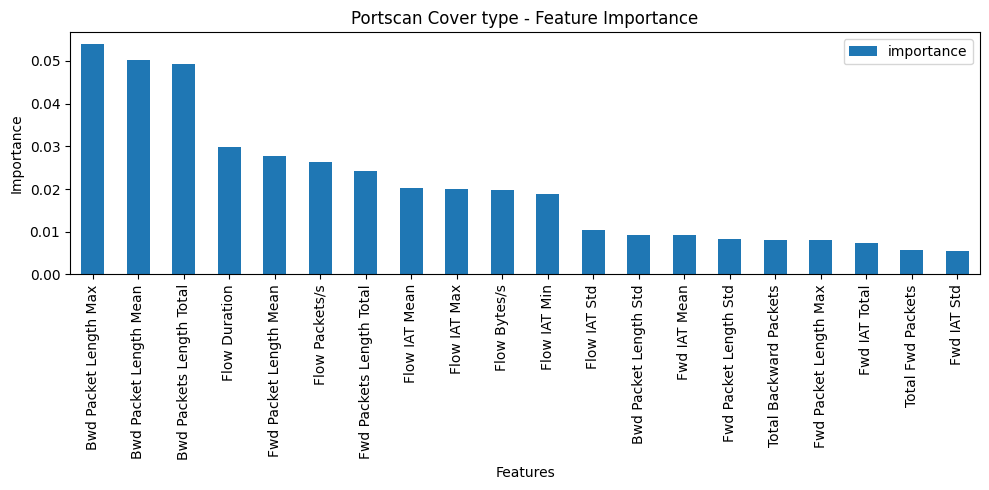

-----------------------------------------------------------------------------------------------




Processing CSV file: DDoS.csv
DDoS importance list:
DDoS 
                           importance
Features                            
Fwd Packet Length Mean      0.056224
Fwd Packets Length Total    0.053776
Fwd Packet Length Max       0.043180
Total Backward Packets      0.038426
Fwd IAT Total               0.029206
Fwd IAT Mean                0.024287
Bwd Packet Length Std       0.023501
Flow Packets/s              0.019991
Bwd Packet Length Mean      0.019767
Flow IAT Max                0.019314
Flow Duration               0.017673
Bwd Packets Length Total    0.016097
Total Fwd Packets           0.015725
Bwd Packet Length Max       0.014929
Flow IAT Mean               0.014695
Fwd Packet Length Std       0.011141
Flow IAT Min                0.008027
Fwd IAT Std                 0.005032
Flow Bytes/s                0.002668
Flow IAT Std                0.002213 



DDoS=["Fwd Packet Lengt

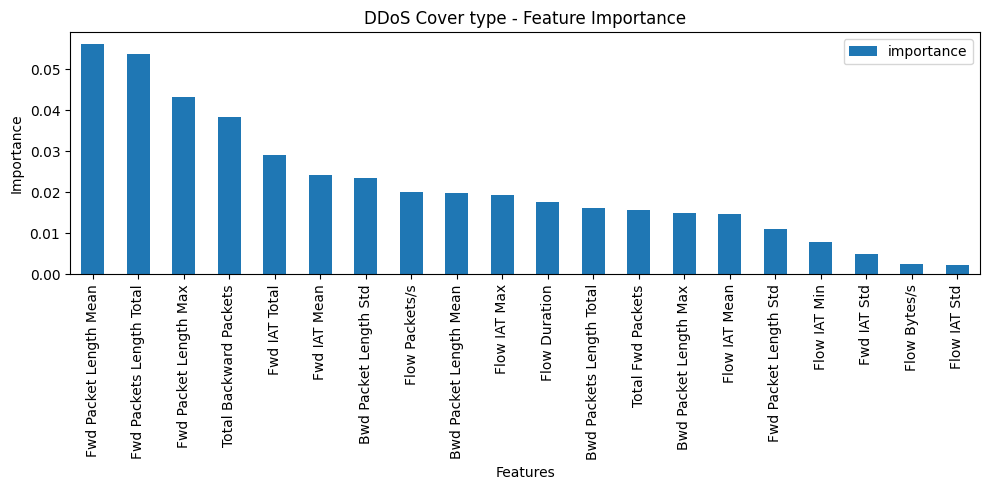

-----------------------------------------------------------------------------------------------




Processing CSV file: Botnet.csv


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x71c2f70724f0>>
Traceback (most recent call last):
  File "/home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


KeyboardInterrupt: 

In [16]:
seconds = time.time()

# CSV files names:
csv_files=os.listdir(OUTPUT_FOLDER)
print('csv_files',csv_files)

feature_importances = {}
KNNs = {}
modelname = "knn"

# Linear way
for csv in csv_files:
    label, important_features, knn, impor_bars = common.process_csv_with_args(csv, 
        main_labels=main_labels, 
        target_column=TARGET_COLUMN, 
        normal_target=NORMAL_TARGET, 
        numerical_columns=NUMERICAL_COLUMNS, 
        output_folder=OUTPUT_FOLDER,
        scaler=scaler,
        modelname=modelname)
    feature_importances[label] = important_features
    KNNs[label] = knn
    common.show_feature_importance(impor_bars, label, FEATURE_FOLDER)
    print("-----------------------------------------------------------------------------------------------\n\n\n\n")

# process_csv_with_args = partial(
#         common.process_csv, 
#         main_labels=main_labels, 
#         target_column=TARGET_COLUMN, 
#         normal_target=NORMAL_TARGET, 
#         numerical_columns=NUMERICAL_COLUMNS, 
#         output_folder=OUTPUT_FOLDER,
#         scaler=scaler 
#     )

# with ProcessPoolExecutor() as executor:
#         results = list(executor.map(process_csv_with_args, csv_files))

# # Collect results from the futures
# for label, important_features, knn, impor_bars in results:
#     feature_importances[label] = important_features
#     KNNs[label] = knn

#     # Show feature importance
#     common.show_feature_importance(impor_bars, label, FEATURE_FOLDER)
#     print("-----------------------------------------------------------------------------------------------\n\n\n\n")

print('feature_importances:', feature_importances)
print("Total operation time: =", time.time() - seconds, "seconds")

In [ ]:
seconds = time.time()

# Define the model
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_df, y_train_df)

# Predict classes for the test set
test_predictions = rf.predict(X_test_df)
print('test_predictions', test_predictions)

print("Total operation time: = ", time.time() - seconds, "seconds")

In [ ]:
pn = "experimental-pipeline-3-" + project_name
wandb.init(project=pn, name="classification")
common.evaluate(y_test_df, test_predictions, heading='Multiclass Classification Evaluation')
wandb.finish()

In [ ]:
seconds = time.time()
CONF_THRESHOLD = 0.95

def predict_knn(predicted_label, test_instance_df):
    selected_features = feature_importances[predicted_label]
    knn_model = KNNs[predicted_label]
    # Select features for the KNN
    test_instance_selected_df = test_instance_df[selected_features]
    knn_prediction = knn_model.predict(test_instance_selected_df)
    # print(knn_prediction)
    normal_class_prob = knn_prediction[:, 1]
    abnormal_class_prob = knn_prediction[:, 0]
    
    return (abnormal_class_prob, normal_class_prob)
    
def process_instance(i, test_instance_df):
    if test_predictions[i] == NORMAL_TARGET:
        max_prob = CONF_THRESHOLD
        final_class_1 = NORMAL_TARGET
        final_class_2 = final_class_1

        for key, knn in KNNs.items():
            sub_abnormal_class_prob, sub_normal_class_prob = predict_knn(key, test_instance_df)
            if sub_abnormal_class_prob > sub_normal_class_prob and sub_abnormal_class_prob > max_prob:
                max_prob = sub_abnormal_class_prob
                final_class_2 = INV_TARGET_DICT[key]

        status = ''
        if final_class_1 != final_class_2 and final_class_2 == y_test_df.iloc[i]:
            status = 'NORMAL improve'
            print('final_class1', final_class_1, 'final_class2', final_class_2, 'actual', y_test_df.iloc[i], status, max_prob)
        if final_class_1 != final_class_2 and final_class_1 == y_test_df.iloc[i]:
            status = 'NORMAL deprove'
            print('final_class1', final_class_1, 'final_class2', final_class_2, 'actual', y_test_df.iloc[i], status, max_prob)

    else:
        predicted_label = TARGET_DICT[test_predictions[i]]
        abnormal_class_prob, normal_class_prob = predict_knn(predicted_label, test_instance_df)
        max_prob = abnormal_class_prob if abnormal_class_prob > normal_class_prob else normal_class_prob
        final_class_1 = INV_TARGET_DICT[predicted_label] if abnormal_class_prob > normal_class_prob else NORMAL_TARGET
        final_class_2 = final_class_1

        if normal_class_prob > 1.0 - CONF_THRESHOLD and normal_class_prob < CONF_THRESHOLD:
            for key, knn in KNNs.items():
                if key != predicted_label:
                    sub_abnormal_class_prob, sub_normal_class_prob = predict_knn(key, test_instance_df)
                    if sub_abnormal_class_prob > sub_normal_class_prob and sub_abnormal_class_prob > max_prob:
                        max_prob = sub_abnormal_class_prob
                        final_class_2 = INV_TARGET_DICT[key]

        status = ''
        if final_class_1 != final_class_2 and final_class_2 == y_test_df.iloc[i]:
            status = 'improve'
            print('final_class1', final_class_1, 'final_class2', final_class_2, 'actual', y_test_df.iloc[i], status, normal_class_prob, max_prob)
        if final_class_1 != final_class_2 and final_class_1 == y_test_df.iloc[i]:
            status = 'deprove'
            print('final_class1', final_class_1, 'final_class2', final_class_2, 'actual', y_test_df.iloc[i], status, normal_class_prob, max_prob)

    return i, final_class_2

# Run all test data instances in parallel and retain order
knn_predictions = [None] * len(X_test_scaled_df)  # Pre-allocate an array for ordered predictions

with ProcessPoolExecutor() as executor:
    futures = {executor.submit(process_instance, idx, X_test_scaled_df.iloc[idx].to_frame().T): idx for idx in range(len(X_test_scaled_df))}

    for future in as_completed(futures):
        idx, prediction = future.result()
        knn_predictions[idx] = prediction  # Insert each prediction at its respective index

print("Total operation time: = ", time.time() - seconds, "seconds")

In [ ]:
# Evaluate KNN on all test data
pn = "experimental-pipeline-3-" + project_name
wandb.init(project=pn, name="final")

final_knn_predictions_df = pd.DataFrame(knn_predictions, columns=[TARGET_COLUMN])
common.evaluate(y_test_df, final_knn_predictions_df, heading='KNN Evaluation (overall)')
wandb.finish()